In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
import numpy as np
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class BioClinicalBERTEncoder(nn.Module):
    def __init__(self, proj_dim=256):
        super().__init__()
        self.model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
        
        for param in self.model.parameters():
            param.requires_grad = False  
        self.model.eval() 

        self.proj = nn.Linear(self.model.config.hidden_size, proj_dim)

    @torch.no_grad() 
    def _encode_bert(self, input_ids, attention_mask):
        return self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

    def forward(self, input_ids, attention_mask):
        batch_size, num_phrases, max_length = input_ids.shape
        input_ids = input_ids.view(-1, max_length)  
        attention_mask = attention_mask.view(-1, max_length)

        cls_embedding = self._encode_bert(input_ids, attention_mask)[:, 0, :] 
        cls_embedding = self.proj(cls_embedding) 
        cls_embedding = F.normalize(cls_embedding, p=2, dim=-1)
        cls_embedding = cls_embedding.view(batch_size, num_phrases, -1)
        cls_embedding = cls_embedding.mean(dim=1)  
        cls_embedding = F.normalize(cls_embedding, p=2, dim=-1) 
        return cls_embedding


class SwinEncoder(nn.Module):
    def __init__(self, model_name="swin_base_patch4_window7_224", proj_dim=256):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=True, num_classes=0, global_pool="avg")
        self.proj = nn.Linear(self.model.num_features, proj_dim) 

    def forward(self, x):
        features = self.model(x)
        features = self.proj(features)
        features = nn.functional.normalize(features, p=2, dim=-1)
        return features

class MedCLIPCustom(nn.Module):
    def __init__(self, proj_dim=256):
        super().__init__()
        self.vision_encoder = SwinEncoder(proj_dim=proj_dim)
        self.text_encoder = BioClinicalBERTEncoder(proj_dim=proj_dim)
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

    def forward(self, images, input_ids, attention_mask):
        img_feat = self.vision_encoder(images)  
        txt_feat = self.text_encoder(input_ids, attention_mask) 
        return img_feat, txt_feat

/home/ammar/anaconda3/envs/mariam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os, json, pathlib, random
from collections import defaultdict
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# ────────────────────────── Config ────────────────────────── #
SEED          = 42
DATASET_ROOT  = pathlib.Path("dataset")          # each sub‑folder = one disease
DESC_JSON     = pathlib.Path("revised_descriptions.json") 
random.seed(SEED)

# ───────────────────── Load descriptions ───────────────────── #
with DESC_JSON.open(encoding="utf-8") as f:
    raw_desc = json.load(f)

# Make case‑insensitive lookup → always a single sentence (str)
descriptions = {k.lower(): (v if isinstance(v, str) else v[0]) 
                for k, v in raw_desc.items()}

# ────────── Build (image_path, [sentence], class_id) list ────────── #
image_caption_pairs = []
class_map = {} 

for idx, folder in enumerate(sorted(DATASET_ROOT.iterdir())):
    if not folder.is_dir():
        continue

    disease      = folder.name
    sentence     = descriptions.get(disease.lower())

    if not sentence:
        print(f"[WARN] '{disease}' skipped (no description found)")
        continue

    class_map[disease] = idx

    # add the single sentence to every image
    for img_file in folder.glob("*.[jp][pn]g"):  
        image_caption_pairs.append(
            (img_file.as_posix(), [sentence], idx)
        )

print(f"Prepared {len(image_caption_pairs)} image–caption pairs "
      f"across {len(class_map)} diseases.")


Prepared 17002 image–caption pairs across 28 diseases.


In [2]:
class MedClipDiseaseDataset(Dataset):
    def __init__(self, image_caption_pairs, tokenizer, transform=None, max_length=128, phrases_per_img=1):
        self.items = image_caption_pairs
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_length
        self.K = phrases_per_img

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, phrases, class_id = self.items[idx]
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"[WARN] can't read image '{img_path}': {e}")
            return self.__getitem__(random.randint(0, len(self.items) - 1))

        if self.transform:
            image = self.transform(image)

        # repeat single sentence K times
        chosen = phrases * self.K

        tok = self.tokenizer(
            chosen,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )

        return {
            "image": image,
            "input_ids": tok["input_ids"],
            "attention_mask": tok["attention_mask"],
            "label": torch.tensor(class_id, dtype=torch.long),
        }


In [3]:
def preview_samples_text_only(image_caption_pairs, id_to_disease: dict, per_class: int = 2):
    """
    """
    from collections import defaultdict
    import random
    import pathlib

    # --- group pairs by class‑id ---
    by_class = defaultdict(list)
    for img_path, phrases, cid in image_caption_pairs:
        by_class[cid].append((img_path, phrases))

    # --- print info per class ---
    for cid, samples in sorted(by_class.items()):
        disease_name = id_to_disease.get(cid, f"Label {cid}")
        print(f"\n=== {disease_name} (Label = {cid}) ===")

        chosen = random.sample(samples, k=per_class) if len(samples) >= per_class else random.choices(samples, k=per_class)

        for idx, (img_path, phrases) in enumerate(chosen, 1):
            img_name = pathlib.Path(img_path).name
            print(f"\nImage {idx}: {img_name}")
            for i, phrase in enumerate(phrases, 1):
                print(f"  Phrase {i}: {phrase}")
                
id_to_disease = {idx: name for name, idx in class_map.items()}
preview_samples_text_only(image_caption_pairs, id_to_disease, per_class=2)



=== Adenomyosis in Gravid Uterus (Label = 0) ===

Image 1: Adenomyosis_in_Gravid_Uterus581.jpg
  Phrase 1: This is Adenomyosis in Gravid Uterus.

Image 2: Adenomyosis_in_Gravid_Uterus042.jpg
  Phrase 1: This is Adenomyosis in Gravid Uterus.

=== Balloon Cell Cortical Dysplasia (Label = 1) ===

Image 1: Balloon_Cell_Cortical_Dysplasia392.jpg
  Phrase 1: This is Balloon Cell Cortical Dysplasia.

Image 2: Balloon_Cell_Cortical_Dysplasia212.jpg
  Phrase 1: This is Balloon Cell Cortical Dysplasia.

=== Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis (Label = 2) ===

Image 1: Bilateral_Osgood-Schlatter_Disease_with_Chronic_Inflammatory_Arthritis587.jpg
  Phrase 1: This is Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis.

Image 2: Bilateral_Osgood-Schlatter_Disease_with_Chronic_Inflammatory_Arthritis422.jpg
  Phrase 1: This is Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis.

=== Bilateral Ulnar Impaction Syndrome (Label = 

In [ ]:
import torch
import torch.nn.functional as F

# ──────────────────────────────────────────────────────────────
# Category‑level CLIP loss  (paper‑style)
# ──────────────────────────────────────────────────────────────
def category_contrastive_loss(
    img_emb: torch.Tensor,        # (B, D)  ℓ2‑normalised
    txt_emb: torch.Tensor,        # (B, D)  ℓ2‑normalised
    labels : torch.Tensor,        # (B,)    class ids
    logit_scale: torch.Tensor,    # scalar parameter from model
) -> torch.Tensor:

    B = img_emb.size(0)
    logits = logit_scale.exp() * img_emb @ txt_emb.t()         # (B, B)

    # build Boolean mask G where G[i, j] == 1 iff labels[i] == labels[j]
    pos_mask = labels.unsqueeze(1) == labels.unsqueeze(0)      # (B, B)

    # ───── image‑to‑text term (Eq. 1) ─────
    log_prob_img = F.log_softmax(logits, dim=1)                # over texts
    # sum log‑prob over positives, then average per‑image
    loss_img = -(log_prob_img * pos_mask).sum(dim=1) / pos_mask.sum(dim=1)
    loss_img = loss_img.mean()

    # ───── text‑to‑image term (Eq. 2) ─────
    log_prob_txt = F.log_softmax(logits.t(), dim=1)            # over images
    loss_txt = -(log_prob_txt * pos_mask).sum(dim=1) / pos_mask.sum(dim=1)
    loss_txt = loss_txt.mean()

    return (loss_img + loss_txt) / 2


In [ ]:
import torch
import torch.nn.functional as F

def debug_phrase_usage(model, dataset, device="cpu", k=3):
    """
    Inspect how strongly an image aligns with:
      • the average text embedding of its k phrases
      • each phrase embedding individually
    """
    model = model.to(device).eval()

    # ---- pick one sample from the dataset ----
    sample = dataset[0]                             
    image = sample["image"].unsqueeze(0).to(device) # (1, C, H, W)
    ids   = sample["input_ids"].to(device)          # (K, L)
    mask  = sample["attention_mask"].to(device)     # (K, L)

    with torch.no_grad():
        txt_avg = model.text_encoder(ids.unsqueeze(0), mask.unsqueeze(0))  # (1, D)

        tokens = model.text_encoder.model(input_ids=ids, attention_mask=mask)
        cls_vecs = tokens.last_hidden_state[:, 0]               # (K, H)
        txt_phrase = model.text_encoder.proj(cls_vecs)          # (K, D)
        txt_phrase = F.normalize(txt_phrase, p=2, dim=-1)

        img_emb = model.vision_encoder(image)                   # (1, D)

    # ---- print cosine similarities ----
    print(f"Image ↔ averaged text cos‑sim : {(img_emb @ txt_avg.T).item():.3f}")
    for i in range(min(k, txt_phrase.size(0))):
        sim = (img_emb @ txt_phrase[i].unsqueeze(1)).item()
        print(f"Image ↔ phrase {i} cos‑sim   : {sim:.3f}")


In [ ]:
from transformers import AutoModel, AutoTokenizer
from torchvision import transforms
from PIL import Image

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
dataset = MedClipDiseaseDataset(image_caption_pairs, tokenizer, transform=image_transform)
model = MedCLIPCustom(proj_dim=256)
debug_phrase_usage(model, dataset, device="cuda")


Image ↔ averaged text cos‑sim : -0.030
Image ↔ phrase 0 cos‑sim   : -0.030


In [ ]:
# ───────────────────── imports ─────────────────────
import random, numpy as np, torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from torchvision import transforms

# ───────── reproducibility ─────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ───────── tokenizer and image transforms ────────
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std =[0.229, 0.224, 0.225]),
])

# ───────── stratified 80 / 20 split ─────────
train_pairs, val_pairs = train_test_split(
    image_caption_pairs,
    test_size=0.20,
    random_state=SEED,
    stratify=[cid for _, _, cid in image_caption_pairs],
)

print(f"Train : {len(train_pairs)} samples")
print(f"Val   : {len(val_pairs)} samples")

# ───────── dataset objects ─────────
train_ds = MedClipDiseaseDataset(
    train_pairs,
    tokenizer,
    transform=image_transform,
    max_length=128,
    phrases_per_img=1,
)
val_ds = MedClipDiseaseDataset(
    val_pairs,
    tokenizer,
    transform=image_transform,
    max_length=128,
    phrases_per_img=1,
)

# ───────── dataloaders ─────────
train_loader = DataLoader(
    train_ds,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
    generator=torch.Generator().manual_seed(SEED),  
)
val_loader = DataLoader(
    val_ds,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available(),
)


Train : 13601 samples
Val   : 3401 samples


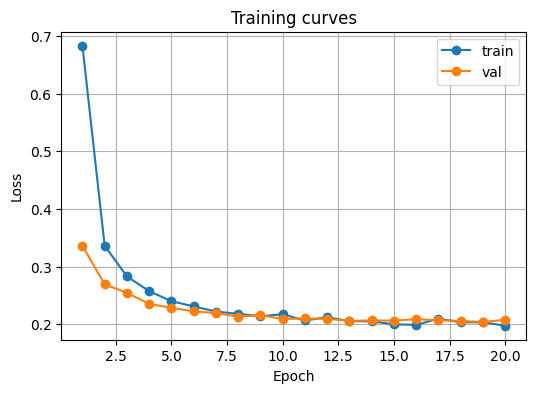

[20/20] train 0.1975 | val 0.2079 | 441.6s

Best validation loss: 0.2040 (epoch 19)
Best model saved to: medCLIP_epochs_One_phrase_New_json/best_model.pth


In [ ]:
# ───────────────────────── IMPORTS ─────────────────────────
import os, time, torch, matplotlib.pyplot as plt, random, numpy as np
from copy import deepcopy
from tqdm import tqdm
from IPython.display import clear_output
from transformers import AutoTokenizer
from torchvision import transforms

# ───────────────────────── ENV / SEEDS ─────────────────────
os.environ["TOKENIZERS_PARALLELISM"] = "false"      
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ───────────────────── TOKENIZER + TRANSFORMS ─────────────
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

# ───────────────────────── MODEL DEFINITION ───────────────
model = MedCLIPCustom(proj_dim=256)  

# ───────────────────────── TRAINING PARAMS ────────────────
NUM_EPOCHS   = 20
LR_BACKBONE  = 1e-5
LR_PROJ      = 1e-3
WEIGHT_DECAY = 1e-4
EMA_MOM      = 0.999
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

# ───────────────────────── DEVICE & EMA ───────────────────
model     = model.to(DEVICE).train()
ema_model = deepcopy(model).eval().requires_grad_(False)

# ───────────────────────── OPTIMIZER ──────────────────────
param_groups = [
    {"params": [p for n, p in model.named_parameters()
                if "vision_encoder" in n and p.requires_grad],
     "lr": LR_BACKBONE, "weight_decay": WEIGHT_DECAY},
    {"params": [p for n, p in model.named_parameters()
                if "vision_encoder" not in n and p.requires_grad],
     "lr": LR_PROJ, "weight_decay": 0.},
]
optimizer = torch.optim.AdamW(param_groups)

# ───────────────────────── FOLDERS & METRICS ──────────────
SAVE_DIR = "medCLIP_epochs_One_phrase_New_json"
os.makedirs(SAVE_DIR, exist_ok=True)
best_val, best_state, best_epoch = float("inf"), None, 0
train_hist, val_hist = [], []

# ───────────────────────── helpers ─────────────────────────
def run_one_epoch(loader, train=True):
    model.train(train)
    total, n = 0.0, 0
    for batch in tqdm(loader, leave=False):
        imgs  = batch["image"].to(DEVICE)
        ids   = batch["input_ids"].to(DEVICE)
        mask  = batch["attention_mask"].to(DEVICE)
        labs  = batch["label"].to(DEVICE)

        img_z, txt_z = model(imgs, ids, mask)
        loss = category_contrastive_loss(img_z, txt_z, labs, model.logit_scale)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                for p_ema, p in zip(ema_model.parameters(), model.parameters()):
                    p_ema.data.mul_(EMA_MOM).add_(p.data, alpha=1-EMA_MOM)

        total += loss.item() * imgs.size(0)
        n     += imgs.size(0)
    return total / n

# ───────────────────────── training loop ───────────────────
for epoch in range(1, NUM_EPOCHS + 1):
    t0 = time.time()
    train_loss = run_one_epoch(train_loader, train=True)
    val_loss   = run_one_epoch(val_loader,   train=False)

    train_hist.append(train_loss)
    val_hist.append(val_loss)

    # ── live plot ──
    clear_output(wait=True)
    plt.figure(figsize=(6,4))
    epochs_range = range(1, epoch + 1)
    plt.plot(epochs_range, train_hist, marker='o', label='train')
    plt.plot(epochs_range, val_hist,   marker='o', label='val')
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training curves")
    plt.grid(True); plt.legend(); plt.show()

    # ── save ONLY if this is the best so far ──
    if val_loss < best_val:
        best_val   = val_loss
        best_state = deepcopy(ema_model.state_dict())
        best_epoch = epoch
        best_path  = os.path.join(SAVE_DIR, f"epoch-{epoch:02d}.pth")
        torch.save(best_state, best_path)
        print(f"🔖  New best val‑loss {best_val:.4f} → saved {best_path}")

    print(f"[{epoch:02}/{NUM_EPOCHS}] "
          f"train {train_loss:.4f} | val {val_loss:.4f} | {(time.time()-t0):.1f}s")

# ───────────────────────── final best copy ─────────────────
final_path = os.path.join(SAVE_DIR, "best_model.pth")
torch.save(best_state, final_path)
print(f"\nBest validation loss: {best_val:.4f} (epoch {best_epoch:02d})")
print(f"Best model saved to: {final_path}")

In [ ]:
import json, os, torch, numpy as np
from pathlib import Path
from PIL import Image
from transformers import AutoTokenizer
from torchvision import transforms
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from collections import defaultdict

# ------------- configuration -------------
CKPT_PATH   = "medCLIP_epochs_One_phrase/best_model.pth" 
DESC_FILE   = "revised_descriptions.json"                
TEST_ROOT   = "testFolder"                       
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN     = 128
TOPKS       = (1, 5, 10)                         
BATCH_SIZE  = 16                                

# ------------- helpers -------------
img_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# ------------ build disease ↔ id maps ------------
with open(DESC_FILE, "r", encoding="utf-8") as f:
    desc = json.load(f)
diseases = sorted(desc.keys())
name2id  = {d: i for i, d in enumerate(diseases)}
id2name  = {i: d for d, i in name2id.items()}

# ------------ load model ------------
model = MedCLIPCustom(proj_dim=256).to(DEVICE).eval()
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE), strict=False)

# ------------ embed all phrases once ------------
phrase_embs, phrase_labels = [], []
with torch.no_grad():
    for disease, phrases in desc.items():
        for text in phrases:
            tok = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            )
            cls = model.text_encoder.model(
                input_ids=tok["input_ids"].to(DEVICE),
                attention_mask=tok["attention_mask"].to(DEVICE)
            ).last_hidden_state[:, 0]                     # (1,H)
            emb = model.text_encoder.proj(cls)            # (1,D)
            emb = torch.nn.functional.normalize(emb, dim=-1)
            phrase_embs.append(emb.squeeze(0))
            phrase_labels.append(name2id[disease])

phrase_embs   = torch.stack(phrase_embs)    # (T,D)
phrase_labels = torch.tensor(phrase_labels, device=DEVICE)  # (T,)

# group indices per class for fast aggregation
class_idx = defaultdict(list)
for idx, cid in enumerate(phrase_labels.cpu().tolist()):
    class_idx[cid].append(idx)
class_idx = {cid: torch.tensor(ix, device=DEVICE)
             for cid, ix in class_idx.items()}

print(f"Embedded {phrase_embs.shape[0]} phrases for {len(diseases)} diseases.")


# ------------ iterate over test images ------------
def iter_test_images(root):
    for disease_dir in sorted(os.listdir(root)):
        cls_path = Path(root) / disease_dir
        if not cls_path.is_dir():
            continue
        for img_file in cls_path.iterdir():
            if img_file.suffix.lower() not in (".jpg", ".jpeg", ".png", ".bmp"):
                continue
            yield img_file.as_posix(), name2id[disease_dir]

def batched(iterable, n):
    batch = []
    for item in iterable:
        batch.append(item)
        if len(batch) == n:
            yield batch
            batch = []
    if batch: 
        yield batch

y_true, y_pred_top1 = [], []
topk_hits = {k: 0 for k in TOPKS}
recip_ranks = []                   

with torch.no_grad():
    for batch in tqdm(batched(list(iter_test_images(TEST_ROOT)), BATCH_SIZE)):
        # -------- load batch images --------
        imgs, labels = zip(*batch)
        pix = torch.stack([img_tfms(Image.open(p).convert("RGB"))
                           for p in imgs]).to(DEVICE)             # (B,3,224,224)
        img_emb = model.vision_encoder(pix)                       # (B,D)

        # -------- similarity to ALL phrases --------
        sims = (model.logit_scale.exp() * img_emb @ phrase_embs.T)  # (B,T)

        # -------- aggregate per disease (mean exp sim) --------
        exp_sims = torch.exp(sims)
        class_scores = torch.zeros(img_emb.size(0), len(diseases), device=DEVICE)
        for cid, idx_tensor in class_idx.items():
            class_scores[:, cid] = exp_sims[:, idx_tensor].mean(dim=1)

        # -------- rankings & metrics --------
        for i, true_id in enumerate(labels):
            y_true.append(true_id)
            sorted_ids = torch.argsort(class_scores[i], descending=True)

            # top‑k hits
            y_pred_top1.append(sorted_ids[0].item())
            for k in TOPKS:
                if true_id in sorted_ids[:k]:
                    topk_hits[k] += 1

            # reciprocal rank for MAP
            rank = (sorted_ids == true_id).nonzero(as_tuple=False).item() 
            recip_ranks.append(1.0 / (rank + 1))

# ------------ metrics ------------
n_samples = len(y_true)
topk_acc = {k: topk_hits[k] / n_samples for k in TOPKS}

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred_top1, labels=list(range(len(diseases))),
    average="macro", zero_division=0
)

map_score = np.mean(recip_ranks)       

print("\n========== Evaluation ==========")
for k, acc in topk_acc.items():
    print(f"Top-{k:<2} accuracy : {acc*100:.2f}%")
print(f"Macro recall        : {recall*100:.2f}%")
print(f"Macro F1            : {f1*100:.2f}%")
print(f"MAP (MRR)           : {map_score*100:.2f}%")

Embedded 1811 phrases for 40 diseases.


508it [01:21,  6.27it/s]


========== Evaluation ==========
Top-1  accuracy : 2.18%
Top-5  accuracy : 11.58%
Top-10 accuracy : 24.27%
Macro recall        : 0.59%
Macro F1            : 0.70%
MAP (MRR)           : 10.45%


In [ ]:
import json, os, torch, numpy as np
from pathlib import Path
from PIL import Image
from transformers import AutoTokenizer
from torchvision import transforms
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from collections import defaultdict

# ------------- configuration -------------
CKPT_PATH   = "medCLIP_epochs_One_phrase_New_json/best_model.pth"   
DESC_FILE   = "revised_descriptions.json"          
TEST_ROOT   = "fewShot"                      
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN     = 128
TOPKS       = (1, 5, 10)                         
BATCH_SIZE  = 16                                 

# ------------- helpers -------------
img_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# ------------ build disease ↔ id maps ------------
with open(DESC_FILE, "r", encoding="utf-8") as f:
    desc = json.load(f)
diseases = sorted(desc.keys())
name2id  = {d: i for i, d in enumerate(diseases)}
id2name  = {i: d for d, i in name2id.items()}

# ------------ load model ------------
model = MedCLIPCustom(proj_dim=256).to(DEVICE).eval()
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE), strict=False)

# ------------ embed all phrases once ------------
phrase_embs, phrase_labels = [], []
with torch.no_grad():
    for disease, phrases in desc.items():
        for text in phrases:
            tok = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=MAX_LEN,
                return_tensors="pt"
            )
            cls = model.text_encoder.model(
                input_ids=tok["input_ids"].to(DEVICE),
                attention_mask=tok["attention_mask"].to(DEVICE)
            ).last_hidden_state[:, 0]                     # (1,H)
            emb = model.text_encoder.proj(cls)            # (1,D)
            emb = torch.nn.functional.normalize(emb, dim=-1)
            phrase_embs.append(emb.squeeze(0))
            phrase_labels.append(name2id[disease])

phrase_embs   = torch.stack(phrase_embs)    # (T,D)
phrase_labels = torch.tensor(phrase_labels, device=DEVICE)  # (T,)

# group indices per class for fast aggregation
class_idx = defaultdict(list)
for idx, cid in enumerate(phrase_labels.cpu().tolist()):
    class_idx[cid].append(idx)
class_idx = {cid: torch.tensor(ix, device=DEVICE)
             for cid, ix in class_idx.items()}

print(f"Embedded {phrase_embs.shape[0]} phrases for {len(diseases)} diseases.")


# ------------ iterate over test images ------------
def iter_test_images(root):
    for disease_dir in sorted(os.listdir(root)):
        cls_path = Path(root) / disease_dir
        if not cls_path.is_dir():
            continue
        for img_file in cls_path.iterdir():
            if img_file.suffix.lower() not in (".jpg", ".jpeg", ".png", ".bmp"):
                continue
            yield img_file.as_posix(), name2id[disease_dir]

def batched(iterable, n):
    batch = []
    for item in iterable:
        batch.append(item)
        if len(batch) == n:
            yield batch
            batch = []
    if batch: 
        yield batch

y_true, y_pred_top1 = [], []
topk_hits = {k: 0 for k in TOPKS}
recip_ranks = []                      

with torch.no_grad():
    for batch in tqdm(batched(list(iter_test_images(TEST_ROOT)), BATCH_SIZE)):
        # -------- load batch images --------
        imgs, labels = zip(*batch)
        pix = torch.stack([img_tfms(Image.open(p).convert("RGB"))
                           for p in imgs]).to(DEVICE)             # (B,3,224,224)
        img_emb = model.vision_encoder(pix)                       # (B,D)

        # -------- similarity to ALL phrases --------
        sims = (model.logit_scale.exp() * img_emb @ phrase_embs.T)  # (B,T)

        # -------- aggregate per disease (mean exp sim) --------
        exp_sims = torch.exp(sims)
        class_scores = torch.zeros(img_emb.size(0), len(diseases), device=DEVICE)
        for cid, idx_tensor in class_idx.items():
            class_scores[:, cid] = exp_sims[:, idx_tensor].mean(dim=1)

        # -------- rankings & metrics --------
        for i, true_id in enumerate(labels):
            y_true.append(true_id)
            sorted_ids = torch.argsort(class_scores[i], descending=True)

            y_pred_top1.append(sorted_ids[0].item())
            for k in TOPKS:
                if true_id in sorted_ids[:k]:
                    topk_hits[k] += 1

            rank = (sorted_ids == true_id).nonzero(as_tuple=False).item()  
            recip_ranks.append(1.0 / (rank + 1))

# ------------ metrics ------------
n_samples = len(y_true)
topk_acc = {k: topk_hits[k] / n_samples for k in TOPKS}

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred_top1, labels=list(range(len(diseases))),
    average="macro", zero_division=0
)

map_score = np.mean(recip_ranks)       

print("\n========== Evaluation ==========")
for k, acc in topk_acc.items():
    print(f"Top-{k:<2} accuracy : {acc*100:.2f}%")
print(f"Macro recall        : {recall*100:.2f}%")
print(f"Macro F1            : {f1*100:.2f}%")
print(f"MAP (MRR)           : {map_score*100:.2f}%")

Embedded 1811 phrases for 40 diseases.


162it [00:24,  6.60it/s]


========== Evaluation ==========
Top-1  accuracy : 0.04%
Top-5  accuracy : 8.48%
Top-10 accuracy : 13.78%
Macro recall        : 0.00%
Macro F1            : 0.01%
MAP (MRR)           : 6.42%
